<a href="https://colab.research.google.com/github/SecrezS/MACDforecasting/blob/main/ANL488_price_3Oct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Import required libraries




In [1]:
# Import required libraries

!pip install pycaret yellowbrick
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import seaborn as sns
import pycaret
from pycaret.regression import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import HuberRegressor
from sklearn.svm import SVR
from yellowbrick.regressor import PredictionError

# Download and extract the libta-lib binaries
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1

# Download and extract the Python wrapper for TA-Lib
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3

# Import TA-Lib
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4063    0  4063    0     0  21025      0 --:--:-- --:--:-- --:--:-- 21051
100  517k  100  517k    0     0   761k      0 --:--:-- --:--:-- --:--:-- 2004k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4035    0  4035    0     0  18729      0 --:--:-- --:--:-- --:--:-- 18767
100  392k  100  392k    0     0   842k      0 --:--:-- --:--:-- --:--:-- 6226k


# Step 2: Download data and prepare main dataframe


In [2]:
# Download data for multiple tickers (SPY, DIA, QQQ, IWM, XLK)
tickers = ["SPY", "DIA", "QQQ", "IWM", "XLK"]
dfs = {}

for ticker in tickers:
    # Download historical data
    df = yf.download(ticker, start="2012-01-01", end="2024-01-01")
    df.reset_index(inplace=True)
    dfs[ticker] = df

# Choose the main dataset for demonstration, SPY
data = dfs["SPY"].copy()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3018 entries, 0 to 3017
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3018 non-null   datetime64[ns]
 1   Open       3018 non-null   float64       
 2   High       3018 non-null   float64       
 3   Low        3018 non-null   float64       
 4   Close      3018 non-null   float64       
 5   Adj Close  3018 non-null   float64       
 6   Volume     3018 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 165.2 KB


# Step 3: Adding technical indicators using TA-Lib

In [4]:
# Adding Technical Indicators using TA-Lib

# Calculate Relative Strength Index (RSI)
data['RSI'] = talib.RSI(data['Adj Close'], timeperiod=14)

# Calculate Moving Average Convergence Divergence (MACD)
data['MACD'], data['MACD_signal'], data['MACD_diff'] = talib.MACD(data['Adj Close'], fastperiod=12, slowperiod=26, signalperiod=9)

# Calculate Average True Range (ATR)
data['ATR'] = talib.ATR(data['High'], data['Low'], data['Adj Close'], timeperiod=14)

# Calculate Bollinger Bands (BB)
data['bb_bbm'], data['bb_bbh'], data['bb_bbl'] = talib.BBANDS(data['Adj Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

# Calculate Keltner Channel (KC)
data['EMA_KC'] = talib.EMA(data['Adj Close'], timeperiod=20)
data['KC_upper'] = data['EMA_KC'] + (data['ATR'] * 1.5)
data['KC_lower'] = data['EMA_KC'] - (data['ATR'] * 1.5)
data['KC'] = (data['Adj Close'] - data['KC_upper']) / data['Adj Close']
data.drop(columns=['EMA_KC', 'KC_upper', 'KC_lower'], inplace=True)

# Calculate Donchian Channel (DC)
data['DC_upper'] = data['High'].rolling(window=20).max()
data['DC_lower'] = data['Low'].rolling(window=20).min()
data['DC_middle'] = (data['DC_upper'] + data['DC_lower']) / 2

# Calculate On-Balance Volume (OBV)
data['OBV'] = talib.OBV(data['Adj Close'], data['Volume'])

# Calculate Chaikin Money Flow (CMF)
cmf_period = 20
data['Money_Flow_Multiplier'] = ((data['Adj Close'] - data['Low']) - (data['High'] - data['Adj Close'])) / (data['High'] - data['Low'])
data['Money_Flow_Volume'] = data['Money_Flow_Multiplier'] * data['Volume']
data['CMF'] = data['Money_Flow_Volume'].rolling(window=cmf_period).sum() / data['Volume'].rolling(window=cmf_period).sum()

# Calculate the Stochastic Oscillator
data['stoch_k'], data['stoch_d'] = talib.STOCH(data['High'], data['Low'], data['Adj Close'],
                                               fastk_period=14,  # The %K period
                                               slowk_period=3,   # The %K slowing period
                                               slowk_matype=0,   # Moving average type for %K (0 = SMA)
                                               slowd_period=3,   # The %D period
                                               slowd_matype=0)   # Moving average type for %D (0 = SMA)

# Calculate the Average Directional Index (ADX)
data['ADX'] = talib.ADX(data['High'], data['Low'], data['Adj Close'], timeperiod=14)

# Set 'Date' as the index
data.set_index('Date', inplace=True)

# Step 4: Create lag features

In [5]:
# List of features to create lag features (exlcude "Adj Close")
features_to_lag = ['Volume', 'RSI', 'MACD', 'MACD_signal',
                   'MACD_diff', 'ATR', 'bb_bbm', 'bb_bbh',
                   'bb_bbl', 'KC','DC_upper', 'DC_lower',
                   'DC_middle','OBV','CMF','stoch_k','stoch_d','ADX']

# Number of lag days to create
lag_days = 20

# Function to create lagged features
def create_lagged_features(df, lag_days, columns):
    for col in columns:
        for lag in range(1, lag_days + 1):
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    return df

# Apply lagged features
data = create_lagged_features(data, lag_days, features_to_lag)
data.dropna(inplace=True)

# Check the resulting DataFrame to confirm new columns
print(data.head())

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2012-03-20  140.050003  140.610001  139.639999  140.440002  111.839806   
2012-03-21  140.520004  140.649994  139.919998  140.210007  111.656624   
2012-03-22  139.179993  139.550003  138.740005  139.199997  110.852318   
2012-03-23  139.320007  139.809998  138.550003  139.649994  111.210655   
2012-03-26  140.649994  141.610001  140.600006  141.610001  112.771484   

               Volume        RSI      MACD  MACD_signal  MACD_diff  ...  \
Date                                                                ...   
2012-03-20  121729700  71.357070  1.443675     1.252665   0.191010  ...   
2012-03-21  122388400  69.497190  1.432619     1.288655   0.143963  ...   
2012-03-22  135216700  61.871764  1.343469     1.299618   0.043851  ...   
2012-03-23  120521000  63.778618  1.286898     1.297074  -0.010176  ...   
2012-03-26  120164000  70.66132

In [6]:
# Drop features that are not lagged
columns_to_drop = ['Open','High','Low','Close','Volume', 'RSI', 'MACD',
                   'MACD_signal', 'MACD_diff', 'ATR', 'bb_bbm', 'bb_bbh',
                   'bb_bbl', 'KC','DC_upper',
                   'DC_lower', 'DC_middle','OBV','CMF','Money_Flow_Multiplier',
                   'Money_Flow_Volume','stoch_k','stoch_d','ADX']

data.drop(columns=columns_to_drop, inplace=True)
data.fillna(method='ffill', inplace=True)

# Step 6: Split the data into train, validation, and test sets

In [7]:
# Split into training, validation, and test sets
train_data = data[data.index < "2022-01-01"]
validation_data = data[(data.index >= "2022-01-01") & (data.index < "2023-01-01")]
test_data = data[data.index >= "2023-01-01"]

# Display the sizes of each set to ensure proper segregation
print(f"Training set: {train_data.shape}")
print(f"Validation set: {validation_data.shape}")
print(f"Test set: {test_data.shape}")

Training set: (2464, 361)
Validation set: (251, 361)
Test set: (250, 361)


# Step 7: Identify important features using RandomForest

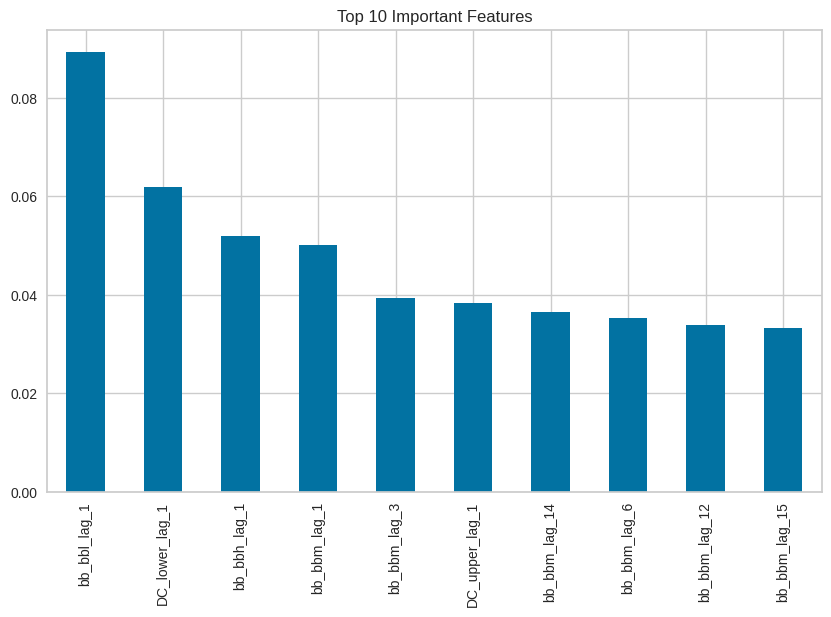

['bb_bbl_lag_1',
 'DC_lower_lag_1',
 'bb_bbh_lag_1',
 'bb_bbm_lag_1',
 'bb_bbm_lag_3',
 'DC_upper_lag_1',
 'bb_bbm_lag_14',
 'bb_bbm_lag_6',
 'bb_bbm_lag_12',
 'bb_bbm_lag_15',
 'bb_bbm_lag_2',
 'bb_bbm_lag_13',
 'DC_upper_lag_18',
 'bb_bbh_lag_17',
 'bb_bbm_lag_7',
 'bb_bbm_lag_17',
 'bb_bbh_lag_13',
 'bb_bbh_lag_10',
 'bb_bbm_lag_9',
 'bb_bbh_lag_19',
 'DC_middle_lag_1',
 'DC_upper_lag_12',
 'bb_bbm_lag_10',
 'bb_bbh_lag_20',
 'bb_bbh_lag_14',
 'bb_bbm_lag_4',
 'DC_upper_lag_4',
 'bb_bbh_lag_11',
 'bb_bbm_lag_11']

In [8]:
X_train = train_data.drop(columns=['Adj Close'])
y_train = train_data['Adj Close']

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Identify important features (features with importance > 0.01, contributes at least 1% to the model's predictive ability)
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
selected_features = feature_importances[feature_importances > 0.01].index.tolist()

# Plot the top 10 important features
plt.figure(figsize=(10, 6))
feature_importances.head(10).plot(kind='bar')
plt.title('Top 10 Important Features')
plt.show()

# Show the selected features
selected_features

In [9]:
# Use only the selected features
train_data_selected = train_data[selected_features + ['Adj Close']]
validation_data_selected = validation_data[selected_features + ['Adj Close']]
test_data_selected = test_data[selected_features + ['Adj Close']]

# Step 8: Setup regression model using PyCaret

In [10]:
# Setup regression model using PyCaret for predicting returns
regression_setup = setup(
    data=train_data_selected,
    target='Adj Close',
    fold_strategy='timeseries',  # Time series cross-validation
    fold=5,                      # Use 5 folds for cross-validation
    session_id=42,
    use_gpu=False,
    data_split_shuffle=False,    # Ensure data is not shuffled
    fold_shuffle=False           # Ensure folds are not shuffled
)

,Description,Value
0,Session id,42
1,Target,Adj Close
2,Target type,Regression
3,Original data shape,"(2464, 30)"
4,Transformed data shape,"(2464, 30)"
5,Transformed train set shape,"(1724, 30)"
6,Transformed test set shape,"(740, 30)"
7,Numeric features,29
8,Preprocess,True
9,Imputation type,simple


# Step 9: Compare models and select the top 3

In [11]:
# Compare different models
best_model = compare_models(n_select=3, sort='RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,2.1409,10.1974,2.9405,0.8557,0.0155,0.0113,1.4600
ridge,Ridge Regression,2.1628,10.3234,2.9665,0.8546,0.0156,0.0114,0.0340
br,Bayesian Ridge,2.1867,10.4834,2.9829,0.8533,0.0157,0.0116,0.0560
huber,Huber Regressor,2.3883,12.4896,3.2438,0.8326,0.0172,0.0128,0.0760
en,Elastic Net,2.6484,14.5028,3.5572,0.8044,0.0187,0.0140,0.0400
lasso,Lasso Regression,2.7579,16.0074,3.7363,0.7844,0.0197,0.0146,0.0380
llar,Lasso Least Angle Regression,2.7849,16.1983,3.7508,0.7826,0.0197,0.0147,0.0300
par,Passive Aggressive Regressor,3.2684,20.8988,4.2951,0.7319,0.0225,0.0174,0.0340
omp,Orthogonal Matching Pursuit,3.4878,20.6962,4.3434,0.7377,0.0228,0.0184,0.0300
et,Extra Trees Regressor,12.3775,253.3469,14.5613,-1.4770,0.0777,0.0634,0.6640


Processing:   0%|          | 0/83 [00:00<?, ?it/s]

# Step 10: Evaluate models using the validation set







In [12]:
# Evaluate the models on the validation set
validation_X = validation_data_selected.drop(columns=['Adj Close'])
validation_y = validation_data_selected['Adj Close']

# List to store evaluation results
evaluated_models = []
for model in best_model:
    # Fine-tune the model using 5-fold cross-validation
    tuned_model = tune_model(model, optimize='RMSE', fold=5)

    # Make predictions on the validation set using the tuned model
    validation_predictions = predict_model(tuned_model, data=validation_X)

    # Calculate RMSE and R² on the validation set
    val_rmse = np.sqrt(mean_squared_error(validation_y, validation_predictions['prediction_label']))
    val_r2 = r2_score(validation_y, validation_predictions['prediction_label'])

    print(f"Validation RMSE for tuned model {model}: {val_rmse}")
    print(f"Validation R² Score for tuned model {model}: {val_r2}")

    # Append the tuned model and its performance to the list
    evaluated_models.append((tuned_model, val_rmse, val_r2))

# Sort the evaluated models by RMSE in ascending order
evaluated_models.sort(key=lambda x: x[1])

# Select top 3 models based on the lowest RMSE
top_models = [model[0] for model in evaluated_models[:3]]

print("Top models successfully fine-tuned and selected.")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.5256,3.8861,1.9713,0.9552,0.0136,0.0106
1,1.9764,8.3847,2.8956,0.7766,0.0169,0.0116
2,2.2938,9.6447,3.1056,0.8673,0.0181,0.0133
3,1.2433,2.4720,1.5723,0.9846,0.0075,0.0059
4,3.6654,26.5996,5.1575,0.6946,0.0214,0.0152
Mean,2.1409,10.1974,2.9405,0.8557,0.0155,0.0113
Std,0.8436,8.6271,1.2454,0.1085,0.0047,0.0031


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 2 candidates, totalling 10 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


Validation RMSE for tuned model LinearRegression(n_jobs=-1): 10.924066694980064
Validation R² Score for tuned model LinearRegression(n_jobs=-1): 0.8314741624491075


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.5834,4.2034,2.0502,0.9516,0.0141,0.0110
1,1.9710,8.1153,2.8487,0.7837,0.0166,0.0116
2,2.3411,9.8842,3.1439,0.8640,0.0183,0.0135
3,1.2822,2.5797,1.6062,0.9839,0.0077,0.0061
4,3.6963,27.1873,5.2141,0.6878,0.0216,0.0153
Mean,2.1748,10.3940,2.9726,0.8542,0.0157,0.0115
Std,0.8403,8.7960,1.2480,0.1087,0.0047,0.0031


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


Validation RMSE for tuned model Ridge(random_state=42): 10.919529495322513
Validation R² Score for tuned model Ridge(random_state=42): 0.8316141243519446


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.5823,4.1973,2.0487,0.9516,0.0141,0.0110
1,1.9720,8.1034,2.8466,0.7841,0.0166,0.0116
2,2.3631,9.9672,3.1571,0.8629,0.0184,0.0136
3,1.2920,2.6043,1.6138,0.9838,0.0077,0.0062
4,3.7164,27.4951,5.2436,0.6843,0.0218,0.0154
Mean,2.1852,10.4735,2.9820,0.8533,0.0157,0.0116
Std,0.8465,8.9098,1.2575,0.1097,0.0047,0.0031


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Validation RMSE for tuned model BayesianRidge(): 11.01231562606929
Validation R² Score for tuned model BayesianRidge(): 0.8287403276420744
Top models successfully fine-tuned and selected.


#Step 11: Test the models and generate error plots

Testing Model 1: Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['bb_bbl_lag_1', 'DC_lower_lag_1',
                                             'bb_bbh_lag_1', 'bb_bbm_lag_1',
                                             'bb_bbm_lag_3', 'DC_upper_lag_1',
                                             'bb_bbm_lag_14', 'bb_bbm_lag_6',
                                             'bb_bbm_lag_12', 'bb_bbm_lag_15',
                                             'bb_bbm_lag_2', 'bb_bbm_lag_13',
                                             'DC_upper_lag_18', 'bb_bbh_lag_17',
                                             'bb_bbm_lag_7', 'bb_bbm_lag_17',
                                             'bb...
                                             'bb_bbh_lag_20', 'bb_bbh_lag_14',
                                             'bb_bbm_lag_4', 'DC_upper_lag_4',
                                             'bb_bbh_lag_11', 'bb_b

Model 1 - Test RMSE: 6.6969299680700844, Test R² Score: 0.9225548675519282
Testing Model 2: Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['bb_bbl_lag_1', 'DC_lower_lag_1',
                                             'bb_bbh_lag_1', 'bb_bbm_lag_1',
                                             'bb_bbm_lag_3', 'DC_upper_lag_1',
                                             'bb_bbm_lag_14', 'bb_bbm_lag_6',
                                             'bb_bbm_lag_12', 'bb_bbm_lag_15',
                                             'bb_bbm_lag_2', 'bb_bbm_lag_13',
                                             'DC_upper_lag_18', 'bb_bbh_lag_17',
                                             'bb_bbm_lag_7', 'bb_bbm_lag_17',
                                             'bb...
                                             'bb_bbh_lag_20', 'bb_bbh_lag_14',
                                             'bb_bbm_lag_4', 'DC_upper_

Model 2 - Test RMSE: 6.686770813063267, Test R² Score: 0.9227896558335833
Testing Model 3: Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['bb_bbl_lag_1', 'DC_lower_lag_1',
                                             'bb_bbh_lag_1', 'bb_bbm_lag_1',
                                             'bb_bbm_lag_3', 'DC_upper_lag_1',
                                             'bb_bbm_lag_14', 'bb_bbm_lag_6',
                                             'bb_bbm_lag_12', 'bb_bbm_lag_15',
                                             'bb_bbm_lag_2', 'bb_bbm_lag_13',
                                             'DC_upper_lag_18', 'bb_bbh_lag_17',
                                             'bb_bbm_lag_7', 'bb_bbm_lag_17',
                                             'bb...
                                             'bb_bbm_lag_4', 'DC_upper_lag_4',
                                             'bb_bbh_lag_11', 'bb_bbm_la

Model 3 - Test RMSE: 6.7222292627923546, Test R² Score: 0.9219686263573317


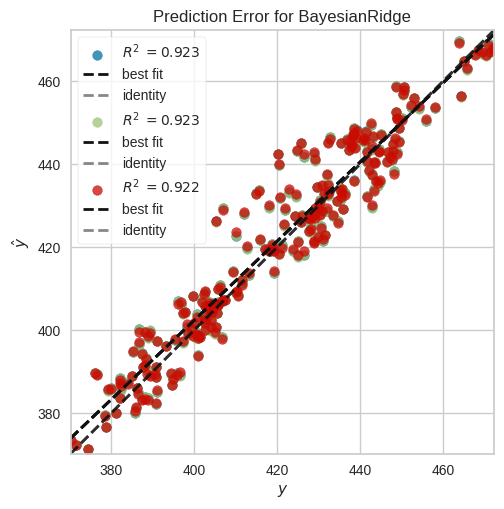

In [13]:
# Ensure that the models are finalized before using them on the test set
final_models = [finalize_model(model) for model in top_models]

# Evaluate the finalized models on the test set
for i, model in enumerate(final_models, start=1):
    print(f"Testing Model {i}: {model}")

    # Drop the 'Adj Close' column from test_data_selected before making predictions
    test_features = test_data_selected.drop(columns=['Adj Close'])

    # Make predictions on the test set using only the features
    predictions = predict_model(model, data=test_features)

    # Calculate RMSE and R² score on the test set using the actual 'Adj Close' values
    rmse = np.sqrt(mean_squared_error(test_data_selected['Adj Close'], predictions['prediction_label']))
    r2 = r2_score(test_data_selected['Adj Close'], predictions['prediction_label'])
    print(f"Model {i} - Test RMSE: {rmse}, Test R² Score: {r2}")

    # Plot the prediction error using Yellowbrick (ensure Yellowbrick is installed)
    visualizer = PredictionError(model)
    visualizer.score(test_features, test_data_selected['Adj Close'])
    visualizer.show(outpath=f'prediction_error_model_{i}.png')  # Save the plot as a PNG file


In [14]:
print('Coefficients:', model.coef_)

Coefficients: [ 0.8474786  -0.17313944  0.72894347  1.4447887  -0.32114762  0.24243437
 -0.50121754 -0.0803367  -0.130037    0.08599556 -0.8560973   0.56690705
 -0.2506593   0.25186092  0.1294405   0.41394475  0.4440372  -4.689603
  0.12928864  1.4827693   0.38074154 -0.32392603 -0.11639412 -1.009206
 -0.14020579 -0.08075295 -0.0224913   2.3176882   0.23309706]


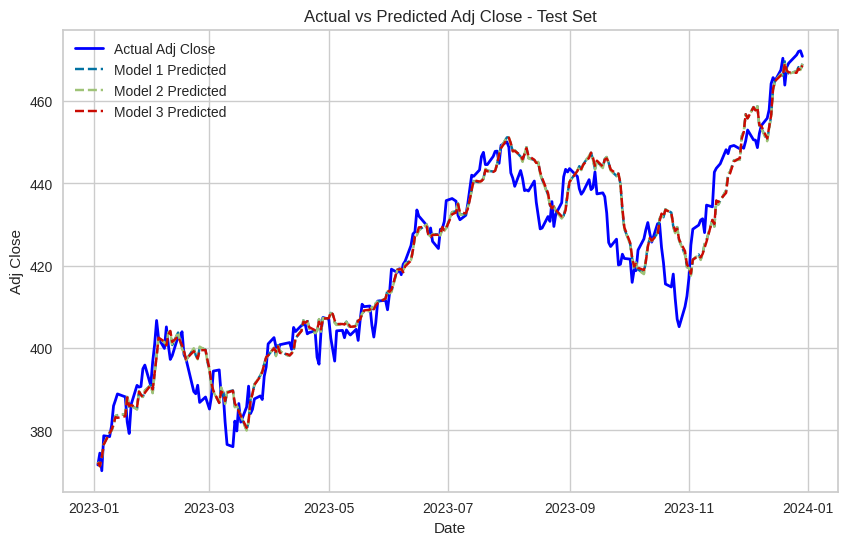

In [18]:
import matplotlib.pyplot as plt

# Assuming you have test_data_selected and predictions from the models
# We'll also assume 'final_models' contains the finalized models for Ridge, Linear, and Bayesian Ridge

# Actual values (from the test set)
actual_values = test_data_selected['Adj Close']

# Create a plot for actual vs. predicted values for each model
plt.figure(figsize=(10, 6))

# Plot actual values
plt.plot(actual_values.index, actual_values, label='Actual Adj Close', color='blue', linewidth=2)

# Plot predicted values for each model
for i, model in enumerate(final_models, start=1):
    # Make predictions
    test_features = test_data_selected.drop(columns=['Adj Close'])
    predictions = predict_model(model, data=test_features)['prediction_label']

    # Plot predicted values
    plt.plot(actual_values.index, predictions, label=f'Model {i} Predicted', linestyle='--')

# Customize the plot
plt.title('Actual vs Predicted Adj Close - Test Set')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
